# Topic Modeling

## *Data Science Unit 4 Sprint 1 Assignment 4*

### Tobias Reaper

---
---

## Assignment

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- <a href="#p1">Fit a Gensim LDA topic model on Amazon Reviews</a>
- <a href="#p2">Select appropriate number of topics</a>
- <a href="#p3">Create some dope visualization of the topics</a>
- <a href="#p4">Write a few bullets on your findings in markdown at the end</a>

**Note**: You don't *have* to use generators for this assignment

<a href="#stretch">Stretch</a>
  
- Named Entities
- Custom pre-processing
- Other data

---

## Resources

- [414 Lecture - Topic Modeling](https://youtu.be/vD5155Hqarg)
- [Topic Modeling with LDA](https://www.youtube.com/watch?v=NYkbqzTlW3w)
- [lettier.com](https://lettier.com/projects/lda-topic-modeling/)
- [gensim](https://radimrehurek.com/gensim/)
  - [tm w gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
- [pyLDAviz](https://github.com/bmabey/pyLDAvis)

---
---

## Imports and Config

In [1]:
# === The Basix === #
import numpy as np
import pandas as pd
import os
import re
import spacy

# === gensim imports === #
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [2]:
# Pandas display configuration
pd.options.display.max_columns = 100

### Load and Look at Dataset

In [3]:
# First we'll have to load the dataset

# Create absolute path to dataset
data_dir = "/Users/Tobias/workshop/buildbox/nlp/DS-Unit-4-Sprint-1-NLP/module1-text-data/data"
data_file = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
data_path = os.path.join(data_dir, data_file)

# Load data into dataframe (no streaming...yet)
df1 = pd.read_csv(data_path)

In [4]:
# First looks for reference
print(df1.shape)
df1.head(2)

(28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."


In [5]:
df1["primaryCategories"].value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Home & Garden                      2
Electronics,Furniture              2
Name: primaryCategories, dtype: int64

In [6]:
# Prune some unneeded columns from the dataframe
df2 = df1[["name", "brand", "categories", "primaryCategories", "reviews.text", "reviews.title"]]

In [7]:
# Look at the result
print(df2.shape)
df2.head()

(28332, 6)


,name,brand,categories,primaryCategories,reviews.text,reviews.title
0,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...
1,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...
2,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...
3,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...
4,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...


---
---

## Fit a Gensim LDA topic model on Amazon Reviews
<a id="#p1"></a>

In [8]:
# Define the tokenizer function
# STOPWORDS = set(STOPWORDS).union(set([""]))

def tokenize(text):
    """Converts text to tokens using gensim.utils.simple_preprocess."""
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [10]:
# Tokenize the text data with pd.apply
df2 = df1.copy()  # No warning about slice copy
df2["tokens"] = df2["reviews.text"].apply(tokenize)

In [11]:
# Take a looksee
df2["tokens"].head()

0    [order, item, bad, quality, missing, backup, s...
1               [bulk, expensive, way, products, like]
2                             [duracell, price, happy]
3              [work, brand, batteries, better, price]
4             [batteries, long, lasting, price, great]
Name: tokens, dtype: object

### Create LDA dictionary

In [12]:
# Dictionary representation of all words in corpus
id2word = corpora.Dictionary(df2["tokens"])

In [14]:
id2word.token2id["battery"]

3

In [15]:
id2word[19]

'batteries'

In [17]:
# Length before filtering
len(id2word.keys())

9622

In [18]:
# Remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [19]:
# Length after filtering
len(id2word.keys())

3582

In [20]:
# Create corpus (bag of words)
corpus = [id2word.doc2bow(token) for token in df2["tokens"]]

In [22]:
# First looks
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [23]:
# ====== Build the LDA topic model ====== #

# Have not yet tinkered with the parameters
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=92,
                   num_topics=15,
                   passes=10,
                   workers=4
                  )

> Notes:

- A good topic model has fairly large, non-overlapping bubbles scattered throughout the plot, not in one quadrant.
- A model with too many topics will usually have smaller bubbles that overlap heavily clustered together in one section.

In [27]:
# Print raw topics
lda.print_topics()[:3]

[(0,
  '0.084*"kindle" + 0.020*"new" + 0.017*"love" + 0.015*"screen" + 0.015*"ipad" + 0.014*"bought" + 0.013*"best" + 0.012*"hd" + 0.011*"like" + 0.010*"old"'),
 (1,
  '0.044*"easy" + 0.033*"use" + 0.028*"size" + 0.027*"screen" + 0.024*"great" + 0.023*"love" + 0.017*"light" + 0.016*"read" + 0.015*"reading" + 0.014*"like"'),
 (2,
  '0.049*"kids" + 0.040*"long" + 0.022*"tablet" + 0.021*"pretty" + 0.020*"battery" + 0.016*"time" + 0.015*"cheap" + 0.014*"great" + 0.011*"love" + 0.011*"life"')]

In [32]:
# Remove stuff before asterisk
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
# Join them into a nice readable list
topics = [' '.join(t[0:5]) for t in words]

# Print out the topics
for id, t in enumerate(topics): 
    print(f"====== Topic {id} ======")
    print(t)
    print()

====== Topic 0 ======
kindle new love screen ipad

====== Topic 1 ======
easy use size screen great

====== Topic 2 ======
kids long tablet pretty battery

====== Topic 3 ======
old year tablet loves kids

====== Topic 4 ======
great price product works tablet

====== Topic 5 ======
battery long life batteries brands

====== Topic 6 ======
better deal time working good

====== Topic 7 ======
amazon money charge product happy

====== Topic 8 ======
batteries work amazon brand long

====== Topic 9 ======
good price batteries quality far

====== Topic 10 ======
gift bought loves tablet christmas

====== Topic 11 ======
books reading read kindle use

====== Topic 12 ======
device amazon battery problem keyboard

====== Topic 13 ======
use tablet amazon play great

====== Topic 14 ======
tablet apps amazon screen great



In [28]:
# Get all the distributions
distro = [lda[d] for d in corpus]

In [29]:
# This is sparse - only lists the ones with distributions
distro[0]

[(9, 0.52109253), (10, 0.13955612), (12, 0.2666239)]

In [30]:
# Hydrate the distributions with the rest of the set
# i.e. the ones without distributions

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [31]:
len(new_distro)

28332

In [33]:
# Create new dataframe with review metadata
df3 = pd.DataFrame.from_records(new_distro, index=df2.index)
df3.columns = topics

In [34]:
df3.head()

,kindle new love screen ipad,easy use size screen great,kids long tablet pretty battery,old year tablet loves kids,great price product works tablet,battery long life batteries brands,better deal time working good,amazon money charge product happy,batteries work amazon brand long,good price batteries quality far,gift bought loves tablet christmas,books reading read kindle use,device amazon battery problem keyboard,use tablet amazon play great,tablet apps amazon screen great
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521093,0.139556,0.000000,0.266624,0.000000,0.000000
1,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.844444,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111
2,0.016667,0.016667,0.016667,0.016667,0.016667,0.315603,0.016667,0.016667,0.016667,0.467730,0.016667,0.016667,0.016667,0.016667,0.016667
3,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.385962,0.469593,0.011111,0.011111,0.011111,0.011111,0.011111
4,0.011111,0.011111,0.011111,0.011111,0.284214,0.011111,0.011111,0.011111,0.571342,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111


---
---

## Find the optimal number of topics

> AKA how to be coherent with yer modeling.

In [40]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model, dictionary=dictionary, corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [41]:
# Suppress DeprecationWarnings within context manager
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    # Can take a long time to run.
    coherence_values = compute_coherence_values(
        dictionary=id2word, 
        corpus=corpus, 
        start=2, 
        limit=40, 
        step=6,
        passes=20
    )

In [42]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [44]:
topic_coherence.head(16)

,coherence_score,num_topics,pass
0,-2.509117,2,0
1,-2.701699,8,0
2,-2.727865,14,0
3,-2.896626,20,0
4,-2.987743,26,0
5,-3.038567,32,0
6,-3.229541,38,0
7,-2.590670,2,1
8,-2.645420,8,1
9,-2.656880,14,1


In [47]:
topic_coherence.max()

coherence_score    -2.509117
num_topics         38.000000
pass               19.000000
dtype: float64

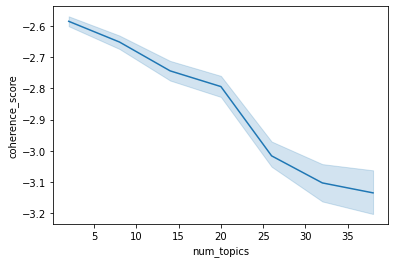

In [49]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence);

---
---

## Create some *DOPE* visualizations of the topics
<a id="#p3"></a>

> Topic Distance Visualization

In [35]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [37]:
# Generate the interactive LDA visualization
# A good topic model has fairly large, non-overlapping bubbles
# scattered throughout the plot, not in one quadrant

# A model with too many topics will usually have smaller bubbles
# that overlap heavily clustered together in one section

pyLDAvis.gensim.prepare(lda, corpus, id2word)

/Users/Tobias/.vega/nlp-9igaqrSk/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.208840 -0.010257       1        1  14.266382
3     -0.230189  0.010307       2        1  11.405455
14    -0.132044  0.010709       3        1   9.508921
0     -0.093629 -0.110326       4        1   7.138339
1     -0.112515 -0.009990       5        1   6.545892
4      0.004411  0.305092       6        1   6.425577
13    -0.112097  0.028752       7        1   6.415495
12     0.123251 -0.198134       8        1   5.913545
5      0.267279 -0.014894       9        1   5.692238
9      0.243309  0.204764      10        1   5.613237
10    -0.158396  0.011963      11        1   5.517525
11    -0.192540  0.036700      12        1   4.765006
7      0.023545 -0.110849      13        1   4.365071
2      0.020080 -0.067550      14        1   3.392213
6      0.140695 -0.086288      15        1   3.035112, topic_info=     Category         Freq       Term        Total  loglift  logprob
21    Default  8747.000000      great  8747.000000  30.0000  30.0000
34    Default  5845.000000       good  5845.000000  29.0000  29.0000
18    Default  7419.000000  batteries  7419.000000  28.0000  28.0000
17    Default  4863.000000      price  4863.000000  27.0000  27.0000
2433  Default  6704.000000     tablet  6704.000000  26.0000  26.0000
2076  Default  3039.000000     kindle  3039.000000  25.0000  25.0000
1857  Default  2144.000000      loves  2144.000000  24.0000  24.0000
23    Default  2378.000000       long  2378.000000  23.0000  23.0000
521   Default  2072.000000        old  2072.000000  22.0000  22.0000
885   Default  1075.000000       gift  1075.000000  21.0000  21.0000
192   Default  2482.000000       kids  2482.000000  20.0000  20.0000
105   Default  1704.000000       year  1704.000000  19.0000  19.0000
2087  Default  1485.000000      books  1485.000000  18.0000  18.0000
2     Default  2221.000000    battery  2221.000000  17.0000  17.0000
28    Default  3120.000000     bought  3120.000000  16.0000  16.0000
165   Default  1975.000000    product  1975.000000  15.0000  15.0000
755   Default  3012.000000       easy  3012.000000  14.0000  14.0000
946   Default  1222.000000    reading  1222.000000  13.0000  13.0000
1679  Default  1635.000000     screen  1635.000000  12.0000  12.0000
786   Default  1239.000000       read  1239.000000  11.0000  11.0000
31    Default   888.000000  christmas   888.000000  10.0000  10.0000
59    Default  1128.000000       life  1128.000000   9.0000   9.0000
74    Default   841.000000     brands   841.000000   8.0000   8.0000
24    Default  3862.000000     amazon  3862.000000   7.0000   7.0000
7     Default  1341.000000    quality  1341.000000   6.0000   6.0000
652   Default  1676.000000      games  1676.000000   5.0000   5.0000
1548  Default  1752.000000       apps  1752.000000   4.0000   4.0000
96    Default  1488.000000      works  1488.000000   3.0000   3.0000
20    Default  1230.000000      brand  1230.000000   2.0000   2.0000
9     Default  2312.000000       work  2312.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
432   Topic15   256.160889       deal   804.089417   2.3510  -3.5957
196   Topic15    43.603508       okay    78.553879   2.9063  -5.3663
178   Topic15    33.039528    knowing    56.575142   2.9571  -5.6438
445   Topic15   111.737991    quickly   340.894470   2.3795  -4.4253
19    Topic15   289.482635     better  1464.826782   1.8735  -3.4734
259   Topic15    60.601570     update   153.371521   2.5664  -5.0371
230   Topic15    83.112160     faster   271.728394   2.3103  -4.7213
246   Topic15    52.127178   everyday   127.915512   2.5972  -5.1878
77    Topic15    80.785942       hard   278.888489   2.2559  -4.7497
1587  Topic15    82.059128      older   313.467468   2.1547  -4.7340
438   Topic15    38.882767     nicely    78.042282   2.7982  -5.4809
173   Topic15   184.729614       time  2056.158447   1.0852  -3.9226
75 

---
---

## Findings and Conclusions
<a id="#p4"></a>

---
---

## Stretch Goals
<a id="#stretch"></a>

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling